<!--
Notebook: Mini-Project 1
目的：量化金融练习与小型项目记录
作者：<在此填写>
日期：2025-10-07

注意：这是隐藏注释（HTML 注释），在渲染时不会显示。
TODO：
- [ ] 明确数据来源与下载方式
- [ ] 定义评价指标（如年化收益、夏普比率、最大回撤）
- [ ] 列出实验分组与超参数
- [ ] 在结尾加上局限性与改进方向

小贴士：Markdown 中“# 标题”不是注释；如果需要真正隐藏内容，请使用 <!-- ... -->。
-->



# Mini Project — European vs American Options

This mini project shows the **difference between European and American options**
using a very simple and classic model: the **Cox–Ross–Rubinstein (CRR) binomial tree**.

**You will:**
- Implement pricing for **European** and **American** options (calls & puts).
- See that for **non‑dividend** stocks, **American call = European call**.
- See that **American put ≥ European put** due to early exercise.
- Check that **binomial European** price approaches **Black–Scholes** as steps increase.



## Setup


In [2]:

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (8, 4)
np.random.seed(0)



## Black–Scholes 

We only use Black–Scholes to **check** our binomial European prices.


In [6]:

from math import erf

def _phi(x):
    # Standard normal CDF via erf
    return 0.5 * (1.0 + erf(x / math.sqrt(2.0)))

def bs_price(S, K, r, q, sigma, T, is_call=True):
    """
    Black–Scholes European option price.
    """
    if T <= 0 or sigma <= 0 or S <= 0 or K <= 0:
        if is_call:
            return max(0.0, S*math.exp(-q*T) - K*math.exp(-r*T))
        else:
            return max(0.0, K*math.exp(-r*T) - S*math.exp(-q*T))
    d1 = (math.log(S/K) + (r - q + 0.5*sigma*sigma)*T) / (sigma*math.sqrt(T))
    d2 = d1 - sigma*math.sqrt(T)
    if is_call:
        return S*math.exp(-q*T)*_phi(d1) - K*math.exp(-r*T)*_phi(d2)
    else:
        return K*math.exp(-r*T)*_phi(-d2) - S*math.exp(-q*T)*_phi(-d1)



## CRR Binomial Pricing (European & American)

Definitions for $N$ steps with $$\Delta t=T/N:$$
- $$u = e^{\sigma\sqrt{\Delta t}}$$ $$d=1/u$$
- Risk‑neutral prob. $$p = \frac{e^{(r-q)\Delta t} - d}{u-d}$$

**European:** backward induction of **continuation values**
**American:** at each node, take `max(continuation, intrinsic)` to allow early exercise.


In [7]:

def crr_price(S, K, r, q, sigma, T, N, is_call=True, american=False):
    """
    Cox–Ross–Rubinstein (CRR) binomial option price.
    """
    dt = T / N
    u = math.exp(sigma * math.sqrt(dt))
    d = 1.0 / u
    disc = math.exp(-r * dt)
    p = (math.exp((r - q) * dt) - d) / (u - d)
    if not (0.0 <= p <= 1.0):
        raise ValueError("Arbitrage: adjust parameters so 0 <= p <= 1.")

    # Terminal stock prices
    ST = np.array([S * (u**j) * (d**(N-j)) for j in range(N+1)])

    # Terminal payoffs
    if is_call:
        values = np.maximum(ST - K, 0.0)
    else:
        values = np.maximum(K - ST, 0.0)

    # Backward induction
    for t in range(N-1, -1, -1):
        values = disc * (p * values[1:] + (1-p) * values[:-1])
        if american:
            S_layer = np.array([S * (u**j) * (d**(t-j)) for j in range(t+1)])
            if is_call:
                intrinsic = np.maximum(S_layer - K, 0.0)
            else:
                intrinsic = np.maximum(K - S_layer, 0.0)
            values = np.maximum(values, intrinsic)

    return float(values[0])



## Examples

We use one simple parameter set and compare:
- **Calls (q=0):** American ≈ European.  
- **Puts:** American ≥ European.


In [8]:

# Parameters (easy to edit)
S, K = 100.0, 100.0
r, q = 0.03, 0.00
sigma = float(sigma_hat)
T = 1.0
N = 200

# Calls (no dividends): American ≈ European
eu_call = crr_price(S, K, r, q, sigma, T, N, is_call=True,  american=False)
am_call = crr_price(S, K, r, q, sigma, T, N, is_call=True,  american=True)
bs_call = bs_price(S, K, r, q, sigma, T, is_call=True)

print(f"European Call (CRR, N={N}): {eu_call:.4f}")
print(f"American  Call (CRR, N={N}): {am_call:.4f}")
print(f"BS Call (reference)       : {bs_call:.4f}")
print("Note: With q=0, early exercise does not help calls, so European ≈ American.")

# Puts: American ≥ European
eu_put = crr_price(S, K, r, q, sigma, T, N, is_call=False, american=False)
am_put = crr_price(S, K, r, q, sigma, T, N, is_call=False, american=True)

print(f"European Put  (CRR, N={N}): {eu_put:.4f}")
print(f"American  Put  (CRR, N={N}): {am_put:.4f}")
print("Early exercise can add value to puts, so American ≥ European.")


European Call (CRR, N=200): 9.4035
American  Call (CRR, N=200): 9.4035
BS Call (reference)       : 9.4134
Note: With q=0, early exercise does not help calls, so European ≈ American.
European Put  (CRR, N=200): 6.4480
American  Put  (CRR, N=200): 6.7382
Early exercise can add value to puts, so American ≥ European.



## Convergence: CRR European → Black–Scholes

For a European **call** with no dividends, the CRR price approaches Black–Scholes as $$N$$ grows.


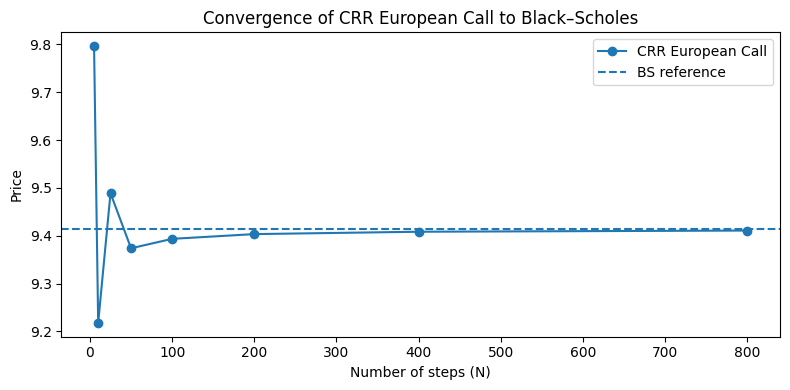

In [7]:

S, K, r, q, sigma, T = 100.0, 100.0, 0.03, 0.0, float(sigma_hat), 1.0
bs_ref = bs_price(S, K, r, q, sigma, T, is_call=True)

steps_list = [5, 10, 25, 50, 100, 200, 400, 800]
crr_prices = []
for N in steps_list:
    c = crr_price(S, K, r, q, sigma, T, N, is_call=True, american=False)
    crr_prices.append(c)

plt.figure()
plt.plot(steps_list, crr_prices, marker='o', label="CRR European Call")
plt.axhline(bs_ref, linestyle='--', label="BS reference")
plt.title("Convergence of CRR European Call to Black–Scholes")
plt.xlabel("Number of steps (N)")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.show()



## American Put — a quick look at early exercise

We visualize where **exercise** is optimal in the tree for an American **put**.  
White (1) = exercise, Black (0) = continue (the figure uses default colors).


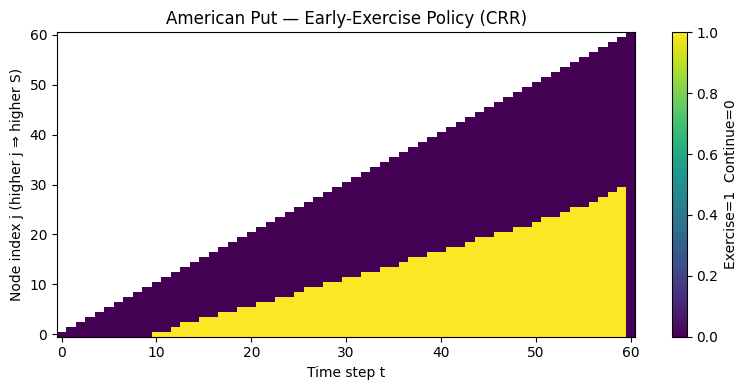

In [14]:

def american_put_policy_grid(S, K, r, q, sigma, T, N):
    dt = T / N
    u = math.exp(sigma * math.sqrt(dt))
    d = 1.0 / u
    disc = math.exp(-r * dt)
    p = (math.exp((r - q) * dt) - d) / (u - d)

    # Precompute stock prices at nodes
    S_nodes = [[S * (u**j) * (d**(t-j)) for j in range(t+1)] for t in range(N+1)]
    # Terminal payoffs
    V = [max(K - sT, 0.0) for sT in S_nodes[N]]

    policy = [[False]*(t+1) for t in range(N+1)]

    for t in range(N-1, -1, -1):
        V_new = []
        for j in range(t+1):
            cont = disc * (p * V[j+1] + (1-p) * V[j])
            intr = max(K - S_nodes[t][j], 0.0)
            if intr > cont:
                V_new.append(intr)
                policy[t][j] = True
            else:
                V_new.append(cont)
        V = V_new
    return policy

S, K, r, q, sigma, T, N_view = 100.0, 100.0, 0.03, 0.0, float(sigma_hat), 1.0, 60
policy = american_put_policy_grid(S, K, r, q, sigma, T, N_view)

# Build a matrix with 1 for exercise, 0 for continue, NaN for padding
grid = np.full((N_view+1, N_view+1), np.nan)
for t in range(N_view+1):
    for j in range(t+1):
        grid[t, j] = 1.0 if policy[t][j] else 0.0

plt.figure()
plt.imshow(grid.T, origin="lower", aspect="auto")
plt.colorbar(label="Exercise=1  Continue=0")
plt.title("American Put — Early-Exercise Policy (CRR)")
plt.xlabel("Time step t")
plt.ylabel("Node index j (higher j ⇒ higher S)")
plt.tight_layout()
plt.show()
